<a href="https://colab.research.google.com/github/gprasad125/lign167_finalproject/blob/main/Copy_of_Project_Tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Multiclass Text Classification to Analyze Famous Quotes 

#### Gokul Prasad & Hoang Nguyen 
#### LIGN 167, Winter 2022

In this project, we'll aim to classify a variety of quotes with tags that refer to certain themes or elements specific to that particular quote. 

For example, Albert Einstein's quote “Life is like riding a bicycle. To keep your balance, you must keep moving.” would have tags like "life" or "simile" because it contains thematic elements about life, and contains a simile. 

In [3]:
# Scraping
import requests
from bs4 import BeautifulSoup
import time 

# Data manipulation / cleaning / visualization
import pandas as pd
import numpy as np
import gensim as gm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import re 
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Sklearn modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.metrics import Precision, Recall

from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Scraping and Cleaning the Data 

We'll be sourcing our data from http://quotes.toscrape.com. This is a website containing 11 pages worth of quotes, each of them classified with a few tags. 

Firstly, we'll loop through the pages, and scrape the website HTML data with BeautifulSoup. Then, we'll use lambda functions to pull author data, quote data, and tag data. We'll put each of these into lists, and then create a pandas DataFrame to hold all our data. 

In [4]:
goodreads_quotes = []
goodreads_tags = []

for i in range(1, 101):

  url = 'https://www.goodreads.com/quotes?page={}'.format(i)

  time.sleep(5)
  scrape = requests.get(url)
  parsed = BeautifulSoup(scrape.content, 'html.parser')

  elements_quotes = parsed.find_all('div', class_ = "quoteText")
  
  quotes = [x.text.strip() for x in elements_quotes]
  tags = parsed.find_all(class_ = 'quoteFooter')

  goodreads_quotes += quotes
  goodreads_tags += tags

In [5]:
data = {'quote':goodreads_quotes, 'tags':goodreads_tags}
goodreads = pd.DataFrame(data)
goodreads.head()

,quote,tags
0,“Be yourself; everyone else is already taken.”...,"[\n, [\n tags:\n , [attributed-no-so..."
1,"“I'm selfish, impatient and a little insecure....","[\n, [\n tags:\n , [attributed-no-so..."
2,“Two things are infinite: the universe and hum...,"[\n, [\n tags:\n , [attributed-no-so..."
3,"“So many books, so little time.”\n ―\n \n ...","[\n, [\n tags:\n , [books], ,\n ..."
4,“A room without books is like a body without a...,"[\n, [\n tags:\n , [attributed-no-so..."


As we can see, our dataset contains some pretty messy strings in all 3 columns. We'll need to process the data to make sure it's usable for our modeling later on. 

For quotes, we'll first make all characters lowercase, and then use regex functionality to substitute any non alphanumeric / whitespace character with a blank string. 

For example, if we input a quote like "I love. LIGN 167!!?" we would receive an output of "i love lign 167". We'll apply this to our Author and Quote columns to clean them up and make them much more simplified strings. 

In [7]:
def quotes_cleaning(text):
    
    text = text.lower()
    
    text = re.sub('[^A-Za-z0-9\s]', '', text)
    
    return text

def tags_cleaning(text):
    
    text = re.sub('[\[ \]]', ' ', str(text))
    text = re.sub('[^\w]', ' ', text)
    text = re.sub('[\s]', ' ', text)
    
    text = ' '.join(text.split())
    
    return text.split(' ')

def remove_author(quote):

  if quote[0] == '“':

    end_of_quote = quote.index('”')
    quote = quote[1:end_of_quote]

  return quote

def bs_to_list(tags):

  if type(tags) != list:

    tags = tags.find_all('a')
  
    tag_strs = []
    for tag in tags[:-1]:

      tag = str(tag)
      start_idx = tag.index('">')
      end_idx = tag.index('</')
      tag = tag[start_idx + 2:end_idx]
      tag_strs.append(tag)

    tags = tag_strs

  return tags

For the tags, we have to a slightly more complicated function since the data is tucked into lists. Firstly, we'll make it a string, and use regex to remove the surrounding brackets, remove non-word characters, and replace all multi-whitespaces with a single space. We'll then render the string as a list again, and return the list. 

For example, if we input a list like [deep?, wonderous.., love-happy], we would get an output of [deep, wonderous, love, happy]

In [10]:
goodreads['quote'] = goodreads['quote'].apply(remove_author)
goodreads['quote'] = goodreads['quote'].apply(quotes_cleaning)
goodreads['tags'] = goodreads['tags'].apply(bs_to_list)
goodreads['tags'] = goodreads['tags'].apply(tags_cleaning)

isEmpty = goodreads['tags'].apply(lambda x: '' in x)
goodreads['isEmpty'] = isEmpty

Now, having cleaned the dataset more fully, we can see the impact on our data. 

In [11]:
goodreads.head(4)

,quote,tags,isEmpty
0,be yourself everyone else is already taken,"[attributed, no, source, be, yourself, gilbert...",False
1,im selfish impatient and a little insecure i m...,"[attributed, no, source, best, life, love, mis...",False
2,two things are infinite the universe and human...,"[attributed, no, source, human, nature, humor,...",False
3,so many books so little time,"[books, humor]",False


# Reshaping Data for Modeling 

Now, while the data is cleaned, we can't really model accurately when our tags are all in a list. Inputting them into our sklearn Pipelines later would not work as we would want, so we have to find a way to reshape the dataframe. Firstly, we'll need to collect the minimum and maximum amount of tags, which we do as follows. 

In [12]:
max_tags = goodreads['tags'].apply(lambda x: len(x)).max()
max_tags

48

So we see that the maximum amount of tags a quote could have would be 11 tags. So, let's generate a function that will make each list of tags equivalent by adding the necessary number of None values to make it to a list of length 11. 

For example, an input of [life, duck, nature] would yield [life, duck, nature, None, None, None, None, None, None, None, None]. 

In [14]:
def pad(tags):

  needed = 48 - len(tags)
  tags = tags + ([None] * needed)

  return tags

Now we can apply that function to our Tags column, and use pandas get_dummies() functionality to reshape our dataframe to where each tag is a column, and the column contains 1s or 0s, reflecting whether or not a particular tag is in the quote belonging to that row. 

Unfortunately, pd.get_dummies() will create some duplicates so we'll groupby and sum to combine the duplicate tag columns. 

We then combine this dataframe with our original dataframe, and drop our tags columns. We can see the finished result

In [15]:
gr_tags = pd.DataFrame(goodreads['tags'].apply(pad).tolist())
gr_tags_oh = pd.get_dummies(gr_tags, prefix = 'tags')
gr_tags_oh = gr_tags_oh.groupby(gr_tags_oh.columns, axis = 1).sum()
reshaped_gr = pd.concat([goodreads, gr_tags_oh], axis = 1).drop(columns = ['isEmpty', 'tags'])
reshaped_gr.head()

,quote,tags_,tags_1,tags_13,tags_1929,tags_1931,tags_1955,tags_1970,tags_1993,tags_1997,...,tags_youth,tags_youthfulness,tags_zarek,tags_zen,tags_zeus,tags_zoe,tags_zombies,tags_zone,tags_zsadist,tags_حب
0,be yourself everyone else is already taken,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,im selfish impatient and a little insecure i m...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,two things are infinite the universe and human...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,so many books so little time,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,a room without books is like a body without a ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see the distribution of tags as below. 31% of our quotes only have 1 tag, while only 1% have the maximum tags possible. 

0       0.001314
1       0.001126
2       0.001032
3       0.000188
4       0.000563
          ...   
2995    0.000375
2996    0.000563
2997    0.000094
2998    0.000469
2999    0.000375
Length: 3000, dtype: float64

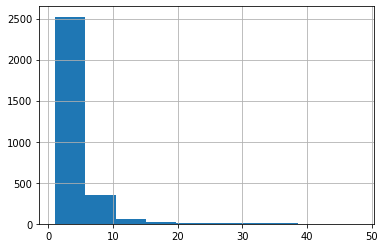

In [17]:
cnts = reshaped_gr.iloc[:, 1:].sum(axis = 1)
cnts.hist()
cnts / cnts.sum()

# Modeling

Now, we can begin our modeling. 

Firstly, we'll get a list of all of our tags. We'll do this by taking all columns besides "Author" and "Quote"

Next, we'll use sklearn's train_test_split() function to split our dataset into a training and testing set. We'll split so that our test set is 33% of our dataset size. As we have 100 rows into our data, then we'll have a training set of 67 rows and testing size of 33 rows. 

In [18]:
gr_tags = reshaped_gr.columns[1:]

train, test = train_test_split(reshaped_gr, test_size = 0.25, random_state = 42)

x_tr = train.quote
x_te = test.quote

print(x_tr.shape)
print(x_te.shape)

(2250,)
(750,)


### Model 1: Decision Tree Classifier

Our first model will be using scikit-learn Pipelines. 

Inside our pipeline, we'll firstly vectorize the input data by converting the quote to their TFIDF formation. This will convert our string Quotes to becoming numerical values for input. Then, we have to consider how we will be handling multiple classes. We'll try with a OneVsRest classifier, because this will allow us to pass in each tag and use an single-class estimator on each tag's train and test data. 

However, we need to wrap the OneVsRest classifier around an estimator that makes sense for what we are trying to achieve here. We'll use a Decision tree classifier, because the sklearn functionality is pretty simplistic, doesnt require much shaping of the data, and should hopefully set a good basis for our first try. 

In [19]:
dt_classifier = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(DecisionTreeClassifier()))])

Now, we'll loop through each of the tags in our dataset, train our model on that particular tag, and then append it to a dictionary containg each tag and that tag's associated evaluation score. 

For our evaluating metric, we'll choose to use f1 scores over accuracy, because if we look at our data, we have an imbalance of tags. Some quotes have several tags, while others only have one or two. As such, using accuracy would likely not work well for this scenario. 

However, we have multiple classes, so it would not make much sense to get a bunch of f1 scores since each tag would give different results. We can instead collect each tag's precision and recall from when the model's predictions are compared to the actual test data. 

In [20]:
prec_recs = {}
for tag in gr_tags:
    
    dt_classifier.fit(x_tr, train[tag])
    prediction = dt_classifier.predict(x_te)
    
    precision_recall = precision_recall_fscore_support(test[tag], prediction, average = 'macro')
    prec_recs[tag] = precision_recall

So now we can calculate the average precision and recall for our tags by looping through our dictionary, summing up the total of both metrics, and dividing by the number of tags.

In [21]:
sum_precision = 0
sum_recall = 0

for key in prec_recs.keys():
    
    sum_precision += prec_recs[key][0]
    sum_recall += prec_recs[key][1]
    
mean_precision = sum_precision / len(prec_recs.keys())
mean_recall = sum_recall / len(prec_recs.keys())

Now we apply the formula of finding an f1 score which is (2 * p * r) / (p + r)

In [22]:
average_f1 = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
average_f1

0.7169826541146564

So we have an f1 score of about 0.708. F1 scores range from 0 to 1, and the closer they are to 1, the better the model, so we have set up a good baseline for ourselves. But we want to improve on this and make our model better classify our quotes. 

#### Optimizing Model 1  

Now that we have our baseline model, how can we optimize it? 

There are many concepts we can implement into our Pipeline, both from a text classification standpoint, as well as a sklearn standpoint. 

The first method we'll implement is getting rid of stop-words. These are words that appear extremely frequently in human language, and give very little value to our model. Removing them can allow our model to focus more strongly on the more important data. 

In [23]:
stop_words = set(stopwords.words('english'))

Now that we have defined the words to remove, we can try and optimize our other parameters with GridSearchCV. First, we'll need to select what parameters we can optimize. 

In [24]:
parameters = {
    'clf':(DecisionTreeClassifier(),),
    'clf__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
    'clf__min_samples_split': [2, 3, 5, 7, 10, 15, 20],
    'clf__min_samples_leaf': [2, 3, 5, 7, 10, 15, 20]
}

Now we have created the parameters, we can place that into a GridSearchCV and train it on our data. 
Let's print out the best parameters we get. 

In [26]:
grids = GridSearchCV(dt_classifier, param_grid = parameters, cv = 3, return_train_score = True)
for tag in gr_tags:
    grids.fit(x_tr, train[tag])

grids.best_params_

KeyboardInterrupt: ignored

Let's now re-run our training, testing, and calculating of precision and recall to calculate a new and hopefully improved average f1 score. 

In [27]:
dt_classifier = Pipeline([('tdidf', TfidfVectorizer(stop_words = stop_words)), ('dtc', DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 2))])

prec_recs = {}
for tag in gr_tags:
    
    dt_classifier.fit(x_tr, train[tag])
    prediction = dt_classifier.predict(x_te)
    
    precision_recall = precision_recall_fscore_support(test[tag], prediction, average = 'macro')
    prec_recs[tag] = precision_recall

sum_precision = 0
sum_recall = 0

for key in prec_recs.keys():
    
    sum_precision += prec_recs[key][0]
    sum_recall += prec_recs[key][1]
    
mean_precision = sum_precision / len(prec_recs.keys())
mean_recall = sum_recall / len(prec_recs.keys())

average_f1 = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
average_f1

0.781000574625376

So we see a decent improvement from 0.7 --> 0.77, achieved with GridSearchCV and stop_word inclusion to optimize our model. However, we'll take a look at other models / optimizations to see if we can get a heightened score. 

### Model 2: 

In [28]:
goodreads = goodreads[goodreads['isEmpty'] == False]
goodreads_sample = goodreads.sample(frac = 1)
train, test = train_test_split(goodreads_sample, test_size = 0.1, shuffle = True)
val = test.sample(frac=0.5)
test.drop(val.index, inplace=True)
train.shape, test.shape, val.shape

((2253, 3), (125, 3), (126, 3))

In [29]:
from ast import literal_eval
from tensorflow.ragged import constant
from tensorflow.keras import layers

terms = constant(train["tags"].values)
lookup = layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'life', 'inspirational', 'love', 'humor', 'positive', 'books', 'quotes', 'self', 'living', 'reading', 'inspiration', 'of', 'misattributed', 'writing', 'happiness', 'friendship', 'philosophy', 'truth', 'wisdom', 'attributed', 'the', 'source', 'no', 'and', 'death', 'thinking', 'romance', 'jace', 'women', 'poetry', 'optimism', 'hope', 'lessons', 'affirmation', 'pain', 'optimistic', 'courage', 'inspiring', 'inspire', 'to', 'religion', 'funny', 'attitude', 'fear', 'music', 'change', 'strength', 'relationships', 'dreams', 'time', 'loneliness', 'god', 'friends', 'beauty', 'wayland', 'science', 'motivational', 'freedom', 'yourself', 'clary', 'in', 'heart', 'motivation', 'men', 'education', 'art', 'words', 'success', 'sadness', 'on', 'faith', 'determination', 'city', 'trust', 'individuality', 'be', 'reality', 'nature', 'humour', 'fray', 'potter', 'knowledge', 'kindness', 'humanity', 'go', 'empowerment', 'stars', 'peace', 'imagination', 'harry', 'grief', 'future', 'will', 

In [30]:
sample_label = train["tags"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['inspirational']
Label-binarized representation: [[0. 0. 1. ... 0. 0. 0.]]


In [31]:
train["quote"].apply(lambda x: len(x.split(" "))).describe()

count    2253.000000
mean       30.430981
std        45.472488
min         1.000000
25%        12.000000
50%        18.000000
75%        31.000000
max       746.000000
Name: quote, dtype: float64

In [32]:
max_seqlen = 20
batch_size = 12
padding_token = "<pad>"

from tensorflow.data import AUTOTUNE
from tensorflow.data import Dataset

auto = AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = constant(dataframe["tags"].values)
    label_binarized = lookup(labels).numpy()

    dataset = Dataset.from_tensor_slices(
        (dataframe["quote"].values, label_binarized)
    )

    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

train_dataset = make_dataset(train, is_train=True)
validation_dataset = make_dataset(val, is_train=False)
test_dataset = make_dataset(test, is_train=False)

In [33]:
vocabulary = set()
train["quote"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

7477


In [34]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

import tensorflow as tf
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

In [51]:
keras_model = Sequential()
keras_model.add(Dropout(0.2))
keras_model.add(Dense(1000, activation = 'relu'))
keras_model.add(Dense(500, activation = 'relu'))
keras_model.add(Dense(lookup.vocabulary_size(), activation = 'sigmoid'))

keras_model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics=['categorical_accuracy'])
keras_model.build((None, vocabulary_size))
keras_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 7477)              0         
                                                                 
 dense_24 (Dense)            (None, 1000)              7478000   
                                                                 
 dense_25 (Dense)            (None, 500)               500500    
                                                                 
 dense_26 (Dense)            (None, 1981)              992481    
                                                                 
Total params: 8,970,981
Trainable params: 8,970,981
Non-trainable params: 0
_________________________________________________________________


In [52]:
epochs = 20
history = keras_model.fit(train_dataset, validation_data = validation_dataset, epochs = epochs)

Epoch 1/20
188/188 [==============================] - 18s 87ms/step - loss: 0.0448 - categorical_accuracy: 0.1114 - val_loss: 0.0165 - val_categorical_accuracy: 0.0794
Epoch 2/20
188/188 [==============================] - 14s 72ms/step - loss: 0.0169 - categorical_accuracy: 0.2099 - val_loss: 0.0169 - val_categorical_accuracy: 0.1032
Epoch 3/20
188/188 [==============================] - 13s 68ms/step - loss: 0.0139 - categorical_accuracy: 0.3187 - val_loss: 0.0165 - val_categorical_accuracy: 0.1032
Epoch 4/20
188/188 [==============================] - 14s 74ms/step - loss: 0.0107 - categorical_accuracy: 0.4061 - val_loss: 0.0163 - val_categorical_accuracy: 0.1349
Epoch 5/20
188/188 [==============================] - 14s 73ms/step - loss: 0.0084 - categorical_accuracy: 0.4847 - val_loss: 0.0147 - val_categorical_accuracy: 0.1508
Epoch 6/20
188/188 [==============================] - 12s 64ms/step - loss: 0.0062 - categorical_accuracy: 0.5859 - val_loss: 0.0171 - val_categorical_accuracy:

In [53]:
info = keras_model.evaluate(test_dataset)

11/11 [==============================] - 0s 33ms/step - loss: 0.0200 - categorical_accuracy: 0.1440


In [54]:
p = history.history['precision']
r = history.history['recall']

mp = np.mean(p)
mr = np.mean(r)

f1 = (2 * mp * mr) / (mp + mr)
f1

KeyError: ignored

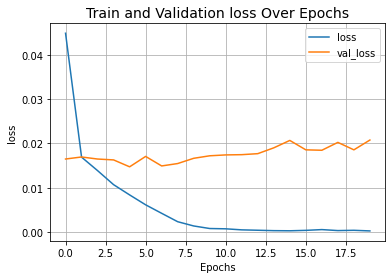

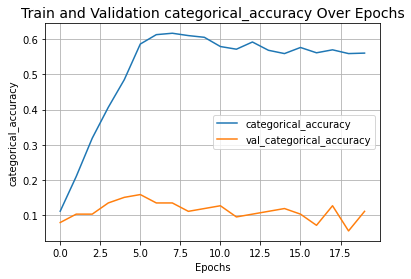

In [56]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")
# plot_result('recall')
# plot_result("precision")